In [1]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [2]:
class FakeArgs:
    def __init__(self):
        self.seed=1
        self.epochs = 10
        self.dataset = "mnist"
        self.num_users=5
        self.iid = 2
        self.dirichlet = 0.5 
        self.local_ep=5
        self.local_bs=64
        self.beta=10.0
    

In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("base_no_beta",FakeArgs())





/home/henry/miniconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 648.672212488511
Finished local epoch 2 out of 10, average loss across batches: 592.5209227489825
Finished local epoch 3 out of 10, average loss across batches: 583.7947023535977
Finished local epoch 4 out of 10, average loss across batches: 578.2992748613117
Finished local epoch 5 out of 10, average loss across batches: 573.9171265674238
Finished local epoch 6 out of 10, average loss across batches: 571.5269652294512
Finished local epoch 7 out of 10, average loss across batches: 569.6785257804294
Finished local epoch 8 out of 10, average loss across batches: 567.164983669249
Finished local epoch 9 out of 10, average loss across batches: 565.4126843364298
Finished local epoch 10 out of 10, average loss across batches: 564.3323010356486
Global Validation user 0 in round 1 totalL: 563.4288418118853 mseL: 536.060620819589 klL: 27.36822093165804
Training user 1 in roun

 10%|█         | 1/10 [01:24<12:41, 84.64s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 644.5695547821045

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 591.3693842527246
Finished local epoch 2 out of 10, average loss across batches: 563.5225614659927
Finished local epoch 3 out of 10, average loss across batches: 559.5094984038537
Finished local epoch 4 out of 10, average loss across batches: 557.4042717428769
Finished local epoch 5 out of 10, average loss across batches: 555.5671248235623
Finished local epoch 6 out of 10, average loss across batches: 555.0164492310596
Finished local epoch 7 out of 10, average loss across batches: 553.7087207441571
Finished local epoch 8 out of 10, average loss across batches: 552.5129027807412
Finished local epoch 9 out of 10, average loss across batches: 552.0170977937073
Finished local epoch 10 out of 10, average loss across batches: 551.4909303809414
Global Validation user 0 in round 2 totalL: 553.1507219243413 mseL: 521.860

 20%|██        | 2/10 [02:43<10:47, 80.95s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 581.0612816345215

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 567.0351003438485
Finished local epoch 2 out of 10, average loss across batches: 555.5018802931329
Finished local epoch 3 out of 10, average loss across batches: 552.8762227547269
Finished local epoch 4 out of 10, average loss across batches: 551.2844822987789
Finished local epoch 5 out of 10, average loss across batches: 550.5236118861607
Finished local epoch 6 out of 10, average loss across batches: 549.557871073234
Finished local epoch 7 out of 10, average loss across batches: 548.7448150891216
Finished local epoch 8 out of 10, average loss across batches: 548.5186098243008
Finished local epoch 9 out of 10, average loss across batches: 547.7270825810793
Finished local epoch 10 out of 10, average loss across batches: 547.2422064773175
Global Validation user 0 in round 3 totalL: 547.3959992850259 mseL: 512.4073

 30%|███       | 3/10 [04:01<09:20, 80.00s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 552.7054778182984

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 559.6427099404215
Finished local epoch 2 out of 10, average loss across batches: 552.0071570131959
Finished local epoch 3 out of 10, average loss across batches: 549.4358920570181
Finished local epoch 4 out of 10, average loss across batches: 547.6736811790146
Finished local epoch 5 out of 10, average loss across batches: 546.7757163168002
Finished local epoch 6 out of 10, average loss across batches: 546.0124119349888
Finished local epoch 7 out of 10, average loss across batches: 545.4019654859014
Finished local epoch 8 out of 10, average loss across batches: 545.2643983985196
Finished local epoch 9 out of 10, average loss across batches: 545.3073484276523
Finished local epoch 10 out of 10, average loss across batches: 544.3029038886062
Global Validation user 0 in round 4 totalL: 544.8980304118651 mseL: 511.235

 40%|████      | 4/10 [05:24<08:06, 81.13s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 546.3725734085083

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 557.1238228934152
Finished local epoch 2 out of 10, average loss across batches: 549.8930982060793
Finished local epoch 3 out of 10, average loss across batches: 547.325457917542
Finished local epoch 4 out of 10, average loss across batches: 545.7816816057477
Finished local epoch 5 out of 10, average loss across batches: 545.1215676700367
Finished local epoch 6 out of 10, average loss across batches: 544.3664007106748
Finished local epoch 7 out of 10, average loss across batches: 543.6179583894104
Finished local epoch 8 out of 10, average loss across batches: 543.0592343626904
Finished local epoch 9 out of 10, average loss across batches: 542.9758705972623
Finished local epoch 10 out of 10, average loss across batches: 542.6176183363971
Global Validation user 0 in round 5 totalL: 542.7598373164519 mseL: 507.9640

 50%|█████     | 5/10 [06:53<06:59, 83.85s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 541.4570422393799

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 554.7338862058496
Finished local epoch 2 out of 10, average loss across batches: 547.6742117745536
Finished local epoch 3 out of 10, average loss across batches: 545.4421350815717
Finished local epoch 4 out of 10, average loss across batches: 544.072542334805
Finished local epoch 5 out of 10, average loss across batches: 543.6104667086561
Finished local epoch 6 out of 10, average loss across batches: 542.810574058725
Finished local epoch 7 out of 10, average loss across batches: 541.9047315581506
Finished local epoch 8 out of 10, average loss across batches: 542.0308194200531
Finished local epoch 9 out of 10, average loss across batches: 541.5443097282858
Finished local epoch 10 out of 10, average loss across batches: 540.7446078773306
Global Validation user 0 in round 6 totalL: 542.7948355742398 mseL: 507.47293

 50%|█████     | 5/10 [07:56<07:56, 95.21s/it]


KeyboardInterrupt: 

In [ ]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [5]:
res.global_model = res.global_model.to('cuda')

In [6]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

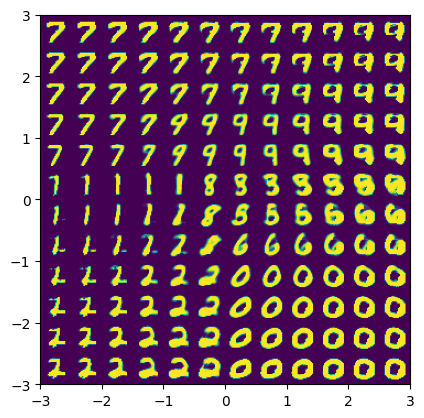

In [7]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


In [ ]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 1.0)


In [ ]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

In [ ]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("point_one",FakeArgs())


In [ ]:

t1_total, t1_mse, t1_kl, v1_total, v1_mse, v1_kl = ClientLossManager.process_data(res.all_losses)

In [ ]:
t2_total, t2_mse, t2_kl, v2_total, v2_mse, v2_kl = ClientLossManager.process_data(second_res.all_losses)


In [ ]:
list(zip(v1_total,v2_total))